In [297]:
# Importing the necessary libraries
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.tools.jupyter import *
from qiskit.visualization import *

from fable import fable
from qiskit import Aer
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import I, Z, X
import pyqsp

# Hamiltonian Estimation

We begin doing hamiltonian estimation by setting up the form of the hamiltonian for a two qubit quantum Ising model.

In [298]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(L, J, h, alpha=0):
    
    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [('ZZ', [i, i + 1], -J) for i in range(0, L-1)]
    Z_tuples = [('Z', [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [('X', [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [299]:
from math import pi
np.set_printoptions(precision=3)

H = get_hamiltonian(L=2, J=.2, h=1., alpha=pi/8).to_matrix()
scale = np.ceil(np.linalg.norm(H))
H_dag = H.conj().T

H

array([[-0.965+0.j, -0.924+0.j, -0.924+0.j, -0.   +0.j],
       [-0.924+0.j,  0.2  +0.j, -0.   +0.j, -0.924+0.j],
       [-0.924+0.j, -0.   +0.j,  0.2  +0.j, -0.924+0.j],
       [-0.   +0.j, -0.924+0.j, -0.924+0.j,  0.565+0.j]])

Notice that the Hamiltonian is real Hermitian, althought our work works for any general Hamiltonian!

# The first step is to find a block encoding of $H$ 
this is achieved by using the Fable library while we will be doing the block encoding for $\exp(-i H t)$ ourselves

In [300]:
simulator = Aer.get_backend("unitary_simulator")


# generate a random matrix and block encode it
N = 4
circ, alpha = fable(H, 0)
result = simulator.run(circ).result()
unitary = result.get_unitary(circ)
np.linalg.norm(alpha * N * unitary.data[0:N, 0:N] - H)/np.linalg.norm(H)

U_gate = circ.to_gate()
U_gate.name = "U"

In [301]:
# reverse the circuit elements
circ_rev = circ.reverse_ops()
U_dag = circ_rev.to_gate()
U_dag.name = "U_dag"

In [302]:
def S1(t):
    circuit = QuantumCircuit(3)
    circuit.x([1,2])
    circuit.ccx(1,2,0)
    # circuit.cx([1,2],0)
    circuit.x([1,2])

    evo = PauliEvolutionGate(Z, time=t)
    circuit.append(evo, [0])

    circuit.x([1,2])
    circuit.ccx(1,2,0)
    # circuit.cx([1,2],0)
    circuit.x([1,2])

    S1_gate = circuit.to_gate()
    S1_gate.name = "S1,"+str(t)
    return S1_gate


def S2(t1, t2):
    circuit = QuantumCircuit(4)
    circuit.x([2,3])
    circuit.ccx(2, 3, 1)
    # circuit.cx([2,3],1)
    circuit.x([2,3])

    evo1 = PauliEvolutionGate(Z, time=t1).control(1)
    circuit.x(1)
    circuit.append(evo1, [0,1])
    circuit.x(1)

    evo2 = PauliEvolutionGate(Z, time=t2).control(1)
    circuit.append(evo2, [0,1])
    circuit.x([2,3])
    circuit.ccx(2,3,1)
    # circuit.cx([2,3],1)
    circuit.x([2,3])

    S2_gate = circuit.to_gate()
    S2_gate.name = "S2,"+str(t1)+","+str(t2)

    return S2_gate


In [303]:
# from pyqsp import *
from scipy.special import jn
import numpy
import time
from pyqsp import angle_sequence
# import poly


def hamiltonian_coefficients(tau, eps):
    n = 2*int(numpy.e / 4 * tau - numpy.log(eps) / 2)
    print(n)
    return jn(numpy.arange(-n, n + 1, 1), tau)

def ham_sim(tau, eps, suc):
    t = time.time()
    a = hamiltonian_coefficients(tau, eps / 10)
    return angle_sequence.angle_sequence(a, .9 * eps, suc), time.time()-t

a = ham_sim(100, 1e-4, 1-1e-4)[0]

146
Completion part finished within time  1.1026005744934082
Decomposition part finished within time  0.29811906814575195
Final error = 4.5002293486072454e-05


In [304]:
len(a)

293

In [305]:
circ = QuantumCircuit(7)
circ.h(range(2))

for i in range(len(a)-2, -1, -2):
    circ.append(S2(a[i], a[i+1]), range(4))
    circ.append(U_dag, range(2,7))

control_u = U_gate.control(1)
circ.data.pop()
circ.append(control_u, [0,2,3,4,5,6])

circ.x([2,3])
circ.ccx(2, 3, 1)
circ.x([2,3])

evo2 = PauliEvolutionGate(Z, time=a[0]).control(1)
circ.append(evo2, [0,1])
circ.x([2,3])
circ.ccx(2,3,1)
circ.x([2,3])

circ.p(-pi/2, 0)
circ.h([0,1])

U_exp = circ.to_gate()
U_exp.name = "U_exp"

circ.reverse_ops()
U_exp_dag = circ.to_gate()
U_exp_dag.name = "U_exp_dag"


# What did we do here?

The cells above found the block encoding of $\kappa \exp(-i H t)/2$ which is not exactly what we want and isn't so trivial to translate into $\exp(-i H t)$. To remedy this, we will need something called amplitude amplification. The specific algorithm we will use is called Oblivious Amplitude Amplification

In [306]:
phi_oaa = [-2*pi/2, pi/2, pi/2, pi/2]
circ = QuantumCircuit(8)
circ.append(S1(phi_oaa[3]), [3,4,0])
circ.append(U_exp, range(1,8))
circ.append(S1(phi_oaa[2]), [3,4,0])
circ.append(U_exp_dag, range(1,8))
circ.append(S1(phi_oaa[1]), [3,4,0])
circ.append(U_exp, range(1,8))
circ.append(S1(phi_oaa[0]), [3,4,0])
circ.x(0)
circ.z(0)
circ.x(0)
circ.draw("mpl")

time_evolve_gate = circ.to_gate()
time_evolve_gate.name = "time_evolve_gate"

/home/hasith/anaconda3/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


# The Final (Condensed) Result

Now that we have the final block encoding, we can simply act on the circuit with it to gather measurments

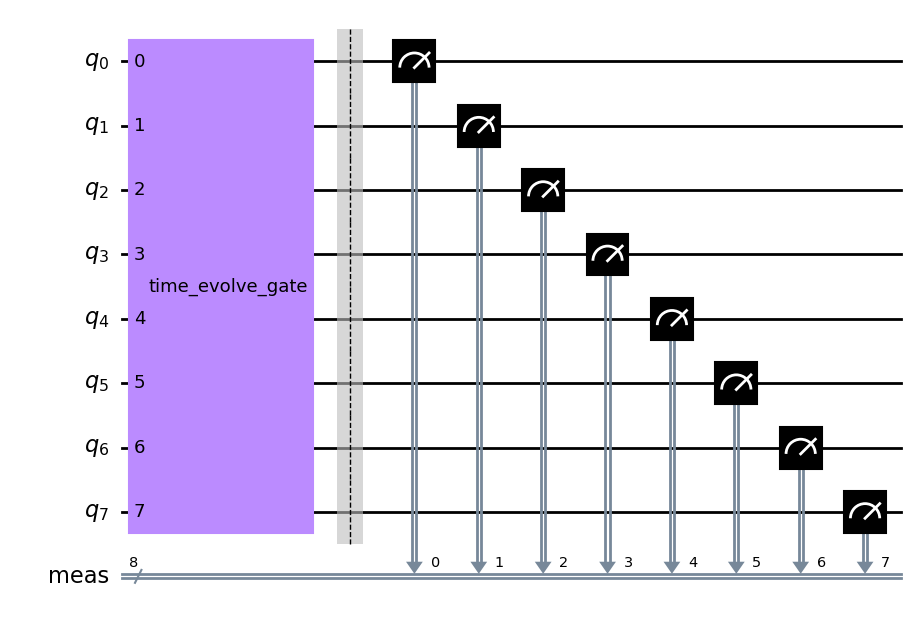

In [307]:
circ = QuantumCircuit(8)
circ.append(time_evolve_gate, range(8))
circ.measure_all()

circ.draw("mpl")

In [308]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import random_unitary, Statevector

qc = QuantumCircuit(8)
statevec = Statevector(qc)
statevec.seed(value=42)

qc.reset(0)
qc.append(time_evolve_gate, range(8))
p0_p1 = statevec.evolve(qc).probabilities(qargs=[3,4]) 
print(p0_p1)

[0.625 0.125 0.125 0.125]


# Application to Ising Model

Now we can see which states of the Ising Model are most likely given our particular choice of hamiltonian, which allows to compute things like specific heat capacity and average magnetiziation

Text(0.5, 1.0, 'Probabilities for each state in two atom Ising model')

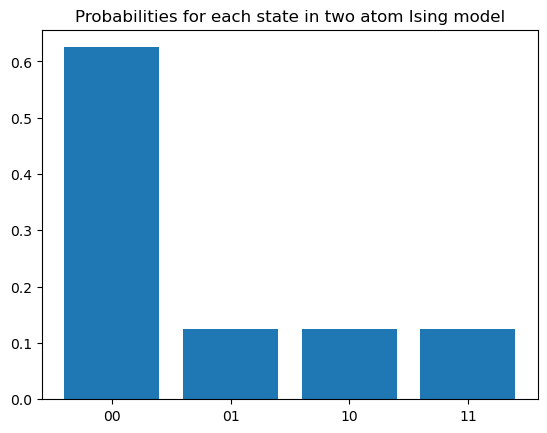

In [310]:
# plot barchart of probabilities
import matplotlib.pyplot as plt
plt.bar(['00', '01', '10', '11'], p0_p1)
plt.title('Probabilities for each state in two atom Ising model')